In [1]:
from SimPEG import Mesh, Utils, EM, Maps
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from SimPEG import Mesh
import pandas as pd

from pathlib import Path
import pandas as pd
import fileinput
# import cartopy

In [5]:
datadir = Path('../data/raw_data')
data17dir = datadir.joinpath('AEM_data_2017_avg')
data19dir = datadir.joinpath('AEM_data_2019_avg')

data17 = datadir.joinpath('AEM_data_2017','MCWD3_SCI1i_MOD_dat.xyz')
data19 = datadir.joinpath('AEM_data_2019','MCWD19_SCI8i_MOD_dat.xyz')

NameError: name 'df17' is not defined

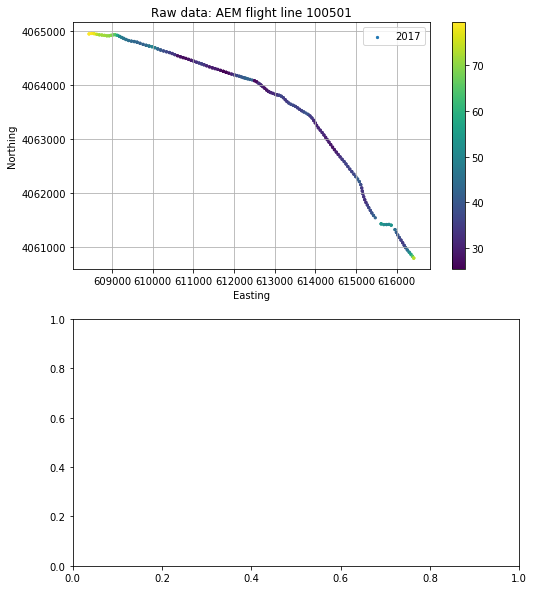

In [7]:
f,axs = plt.subplots(2,1,figsize=(8,10))
plt.sca(axs.flatten()[0])
ax = plt.gca()
plt.scatter(df.loc[df.LINE_NO==line,'UTMX'],
            df.loc[df.LINE_NO==line,'UTMY'],
            s=5,
            c=df.loc[df.LINE_NO==line,'INVALT'],
            label='2017')

plt.grid(True)
plt.colorbar()
plt.legend()
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Raw data: AEM flight line {}'.format(line))



plt.sca(axs.flatten()[1])
ax = plt.gca()
plt.scatter(df17.loc[df17.LINE==line,'X'],
            df17.loc[df17.LINE==line,'Y'],
            s=5,
            c=df17.loc[df17.LINE==line,'INVALT'],
            label='2017')
# plt.scatter(df19.loc[df19.LINE==line,'X'],df19.loc[df19.LINE==line,'Y'],s=1,c='k',label='2019')
plt.grid(True)
plt.colorbar()
plt.legend()
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Inverted data: flight line {}'.format(line))

In [8]:
df = pd.read_pickle(datadir.joinpath('processed_df.pkl'))
line = 100501


In [9]:
#TAKE THE LOCATION OF CHANNEL 1 FOR EACH SOUNDING
msk = np.logical_and(df.CHANNEL_NO==1, df.LINE_NO == line)
xy = df.loc[msk,['UTMX', 'UTMY']].values
Line = df.LINE_NO.values
dem = df.loc[msk,'ELEVATION'].values[:]
height = df.loc[msk,'INVALT'].values[:]
rx_locations = np.c_[xy[:,:], height+dem+2.]
src_locations = np.c_[xy[:,:], height+dem]
topo = np.c_[xy[:,:], dem]
skytem_type = df.skytem_type.values

In [10]:
area = 342
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_312.txt'))
waveform_lm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_312.txt'))
time_input_currents_HM_312 = waveform_hm_312[:,0] 
input_currents_HM_312 = waveform_hm_312[:,1]
time_input_currents_LM_312 = waveform_lm_312[:,0] 
input_currents_LM_312 = waveform_lm_312[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
GateTimeShift=-1.8E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_312 = waveform_lm_312[:,0].max()
times_lm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312

GateTimeShift=-1.4E-06
MeaTimeDelay=6.000E-05
NoGates=37
t0_hm_312 = waveform_hm_312[:,0].max()
times_hm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

In [11]:
area = 342
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_304.txt'))
waveform_lm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_304.txt'))
time_input_currents_HM_304 = waveform_hm_304[:,0] 
input_currents_HM_304 = waveform_hm_304[:,1]
time_input_currents_LM_304 = waveform_lm_304[:,0] 
input_currents_LM_304 = waveform_lm_304[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
GateTimeShift=-2.1E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_304 = waveform_lm_304[:,0].max()
times_lm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_304

GateTimeShift=-1.5E-06
MeaTimeDelay=3.500E-04
NoGates=37
t0_hm_304 = waveform_hm_304[:,0].max()
times_hm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_304    

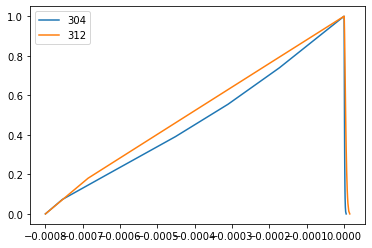

In [12]:
plt.plot(time_input_currents_LM_304, input_currents_LM_304,label='304')
plt.plot(time_input_currents_LM_312, input_currents_LM_312,label='312')
plt.legend()

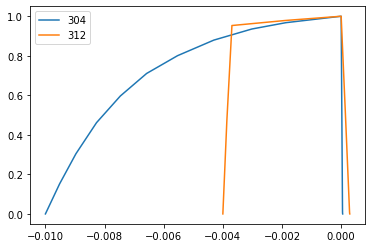

In [13]:
plt.plot(time_input_currents_HM_304, input_currents_HM_304,label='304')
plt.plot(time_input_currents_HM_312, input_currents_HM_312,label='312')
plt.legend()

In [14]:
from SimPEG import (
    Regularization, Directives, Inversion, 
    InvProblem, Optimization, DataMisfit, Utils, Maps
)
from simpegEM1D import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, 
    get_vertical_discretization_time, EM1DSurveyTD,
    get_2d_mesh, LateralConstraint, 
)
from pymatsolver import PardisoSolver
hz_312 = np.loadtxt(datadir.joinpath('AEM_data_2019','thickness.txt'))
hz_304 = np.loadtxt(datadir.joinpath('AEM_data_2017','thickness.txt'))


hz = hz_304
# hz = np.unique(hz_312.values[inds_312,:])* 0.3048
# hz = np.unique(hz_304.values[inds_304,:])* 0.3048
n_sounding = xy.shape[0]
mesh = get_2d_mesh(n_sounding, hz)

ModuleNotFoundError: No module named 'simpegEM1D'

In [133]:
len(times_hm_304)

27

In [177]:
time = []
time_dual_moment = []
input_currents = []
time_input_currents = []
input_currents_dual_moment = []
time_input_currents_dual_moment = []

for i_sounding in range(n_sounding):
    if skytem_type[i_sounding] == 312.:
        time.append(times_hm_312)
        time_dual_moment.append(times_lm_312)
        time_input_currents.append(time_input_currents_HM_312)
        input_currents.append(input_currents_HM_312)
        time_input_currents_dual_moment.append(time_input_currents_LM_312)
        input_currents_dual_moment.append(input_currents_LM_312)        
    else:
        time.append(times_hm_304)
        time_dual_moment.append(times_lm_304)
        time_input_currents.append(time_input_currents_HM_304)
        input_currents.append(input_currents_HM_304)
        time_input_currents_dual_moment.append(time_input_currents_LM_304)
        input_currents_dual_moment.append(input_currents_LM_304)        

NameError: name 'n_sounding' is not defined

In [135]:
len(time_dual_moment[0])

18

In [136]:
# print(survey.nD)
# print(src_locations.shape)
# print(n_sounding)
# print(len(time)*len(time[0]) + len(time_dual_moment)*len(time_dual_moment[0]))
# print(uncert.shape)

In [144]:
mapping = Maps.ExpMap(mesh)

survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations[:,:],
    src_locations = src_locations[:,:],    
    topo = topo[:,:],
    time = time,
    time_dual_moment = time_dual_moment,
    src_type = np.array(["VMD"], dtype=str).repeat(n_sounding),
    rx_type = np.array(["dBzdt"], dtype=str).repeat(n_sounding),    
    offset = np.array([13.25], dtype=float).repeat(n_sounding).reshape([-1,1]),    
    wave_type = np.array(["general"], dtype=str).repeat(n_sounding),    
    field_type = np.array(["secondary"], dtype=str).repeat(n_sounding),    
    input_currents=input_currents,
    time_input_currents=time_input_currents,
    base_frequency = np.array([30.]).repeat(n_sounding),
    input_currents_dual_moment=input_currents_dual_moment,
    time_input_currents_dual_moment=time_input_currents_dual_moment,
    base_frequency_dual_moment = np.array([210.]).repeat(n_sounding),
    moment_type=np.array(["dual"], dtype=str).repeat(n_sounding)
)

prob = GlobalEM1DProblemTD(
    [], sigmaMap=mapping, hz=hz, parallel=True, n_cpu=8,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Set parameters
>> Use multiprocessing for parallelization
>> n_cpu: 8


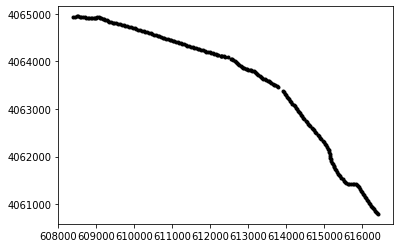

In [145]:
plt.plot(xy[:,0], xy[:,1], 'k.')

In [146]:
m0 = np.ones(mesh.nC) * np.log(1./10)

In [147]:
dpred = survey.dpred(m0)

n_sounding = 19972

nD_vec: 19972 long, 27 data points for each of the soundings (27*19972=539244)


nD = 539244


In [148]:
i_start_hm = 10
i_start_lm = 10

lm_inds = np.array(['DBDT_Ch1' in key.split('GT') for key in df.keys()], dtype=bool)
hm_inds = np.array(['DBDT_Ch2' in key.split('GT') for key in df.keys()], dtype=bool)
lm_header = (df.keys()[lm_inds])[i_start_lm:]
hm_header = (df.keys()[hm_inds])[i_start_hm:]
data_hm = df.loc[np.logical_and(df.CHANNEL_NO==2, df.LINE_NO == line),hm_header].values[:,:]
data_lm = df.loc[np.logical_and(df.CHANNEL_NO==1, df.LINE_NO == line),lm_header].values[:,:]

# dobs = np.hstack((data_hm, data_lm)).flatten() * unit_conversion

In [161]:
floor_hm = 0.
floor_lm = 0.
std = 0.05
data_hm[np.isnan(data_hm)] = 9999.
data_lm[np.isnan(data_lm)] = 9999.
dobs = np.hstack((data_hm/area, data_lm/area)).flatten()
uncert = np.hstack((abs(data_hm/area)*std + floor_hm, abs(data_lm/area)*std + floor_lm)).flatten()
survey.dobs = -dobs.copy() 
inactive_inds = dobs==9999./area
uncert[inactive_inds] = np.Inf




In [162]:
dobs.shape

(10080,)

In [163]:
dpred.shape

(10080,)

In [164]:
print('survey.nD size',survey.nD)
print('uncert size',uncert.size)

survey.nD size 10080
uncert size 10080


In [31]:
len(time)*len(time[0])

539244

In [171]:
mesh = get_2d_mesh(n_sounding, hz)
m0 = np.ones(mesh.nC) * np.log(1./10.)
regmap = Maps.IdentityMap(mesh)
# mapping is required ... for IRLS
reg = LateralConstraint(
    mesh, mapping=regmap,
    alpha_s = 1e-2,
    alpha_x = 10.,
    alpha_y = 1.,    
)
reg.get_grad_horizontal(xy[:,:], hz, dim=3, use_cell_weights=True, minimum_distance=1000.)

np.random.seed(1)
dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.W = 1./uncert
p = 0
qx, qz = 1., 1.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=5, minGNiter=1, fix_Jmatrix=True,
    betaSearch=False
)
opt = Optimization.ProjectedGNCG(maxIter = 30, maxIterCG=20)
# opt.upper = m_upper
# opt.lower = m_lower
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit(chifact=0.84)
sense = Directives.UpdateSensitivityWeights()
save_model = Directives.SaveOutputDictEveryIteration(directory="./l2-m0-10ohmm-smooth/")
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target, save_model, sense])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [172]:
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2020-02-20-13-23.npz'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.02e+05  4.67e+09  0.00e+00  4.67e+09    2.64e+09      0              
   1  5.08e+04  5.66e+08  4.72e-01  5.66e+08    3.31e+08      0              
   2  2.54e+04  7.52e+07  8.59e-01  7.53e+07    6.07e+07      0   Skip BFGS  
   3  1.27e+04  1.12e+07  3.80e+00  1.13e+07    9.60e+06      0   Skip BFGS  
   4  6.35e+03  2.86e+06  1.12e+01  2.93e+06    2.17e+06      0   Skip BFGS  
   5  3.17e+03  1

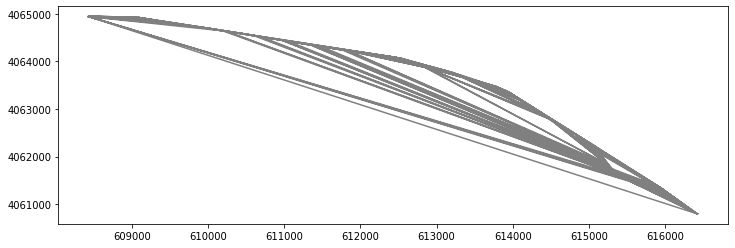

In [174]:
fig = plt.figure(figsize=(12, 4))
tri = reg.get_grad_horizontal(topo[1:,:2], hz)
# plt.plot(topo_312[:,0], topo_312[:,1], 'o')
# plt.plot(topo_304[:,0], topo_304[:,1], 'o')
# plt.legend(("SkyTEM312", "SkyTEM304"))
plt.triplot(topo[1:,0], topo[1:,1], tri.simplices, color='grey')
plt.show()

array([100501., 100501., 100501., 100501., 100501., 100501., 100501.,
       100501., 100501., 100501., 100501., 100501., 100501., 100501.,
       100501., 100501., 100501., 100501., 100501., 100501., 100501.,
       100501., 100501., 100501., 100501., 100501., 100501., 100501.,
       100501., 100501., 100501., 100501., 100501., 100501., 100501.,
       100501., 100501., 100501., 100501., 100501., 100501., 100501.,
       100501., 100501., 100501., 100501., 100501., 100501., 100501.,
       100501., 100501., 100501., 100501., 100501., 100501., 100501.,
       100501., 100501., 100501., 100501., 100501., 100501., 100501.,
       100501., 100501., 100501., 100501., 100501., 100501., 100501.,
       100501., 100501., 100501., 100501., 100501., 100501., 100501.,
       100501., 100501., 100501., 100501., 100501., 100501., 100501.,
       100501., 100501., 100501., 100501., 100501., 100501., 100501.,
       100501., 100501., 100501., 100501., 100501., 100501., 100501.,
       100501., 1005

(<matplotlib.collections.QuadMesh at 0x2b3c594ef890>,
 <matplotlib.colorbar.Colorbar at 0x2b3c59523a50>)

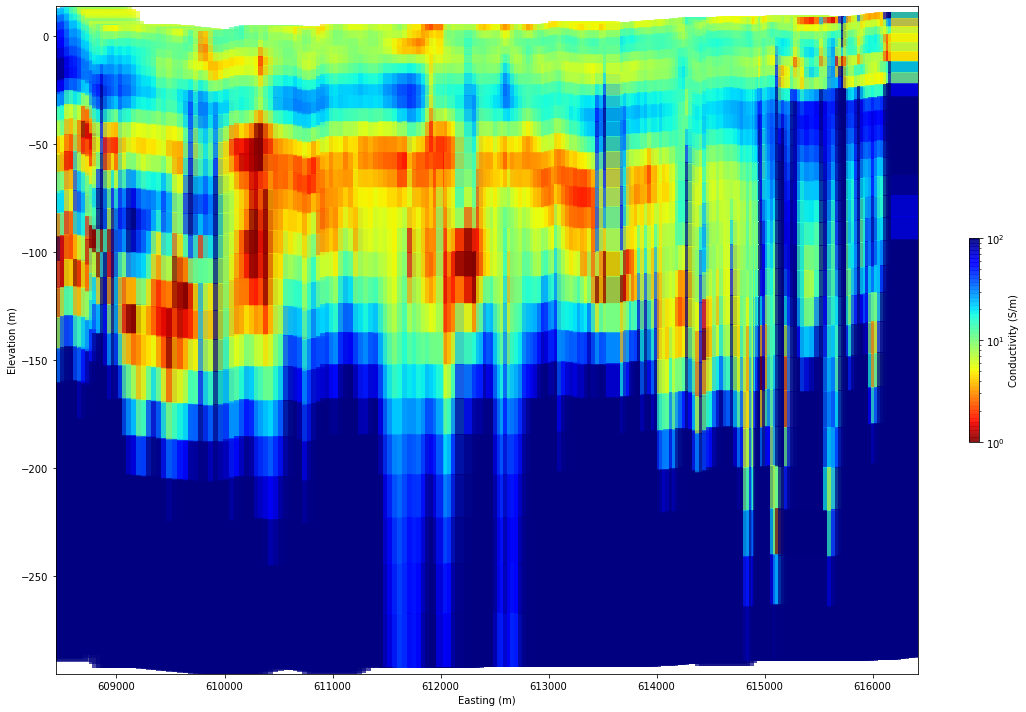

In [185]:
from matplotlib.colors import LogNorm
from simpegEM1D import ModelIO
nskip = 1
IO = ModelIO(
    hz=hz,
    topography=topo[1:,:], 
    physical_property=1./np.exp(Utils.mkvc(mopt.reshape((hz.size, n_sounding), order='F')[:,::nskip])),
    line=np.repeat(line, n_sounding)[::nskip].astype(float)
)

IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r', aspect=20, clim=(1, 100), dx=250, i_line=0)

(1e-14, 1e-08)

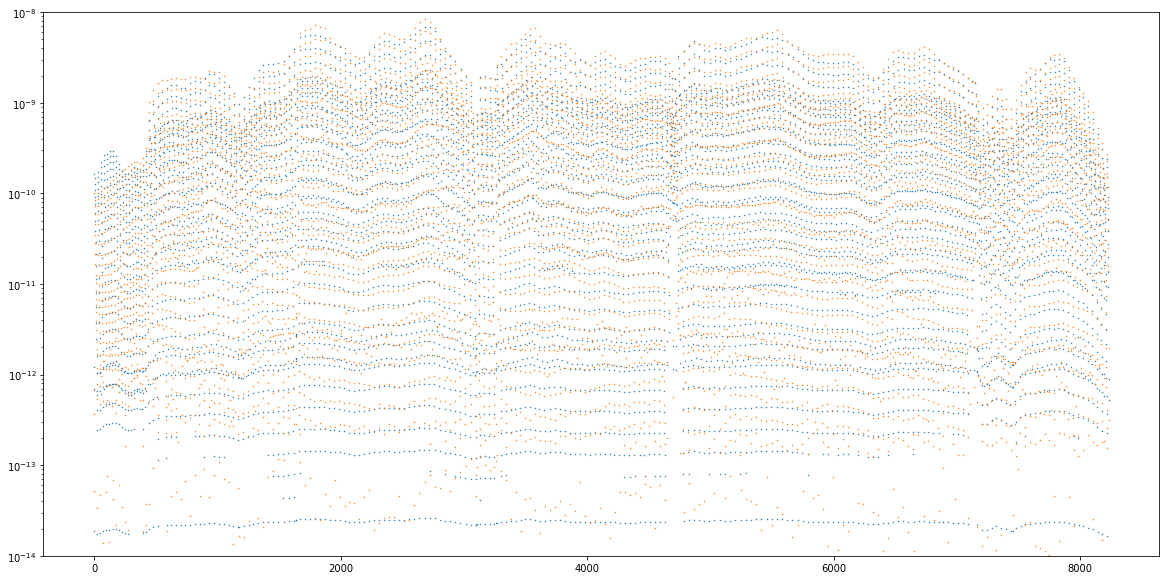

In [200]:
fig = plt.figure(figsize=(20, 10))
plt.semilogy(abs(dpred[~inactive_inds]), '.', ms=1)
plt.semilogy(abs(survey.dobs[~inactive_inds]), '.', ms=1)
plt.ylim(1e-14, 1e-8)

array([-3.35299012, -3.37396148, -3.37906508, ..., -3.30210968,
       -3.30201697, -3.3107969 ])

(<matplotlib.collections.QuadMesh at 0x2b3c5bf7e310>,
 <matplotlib.colorbar.Colorbar at 0x2b3c5bfb14d0>)

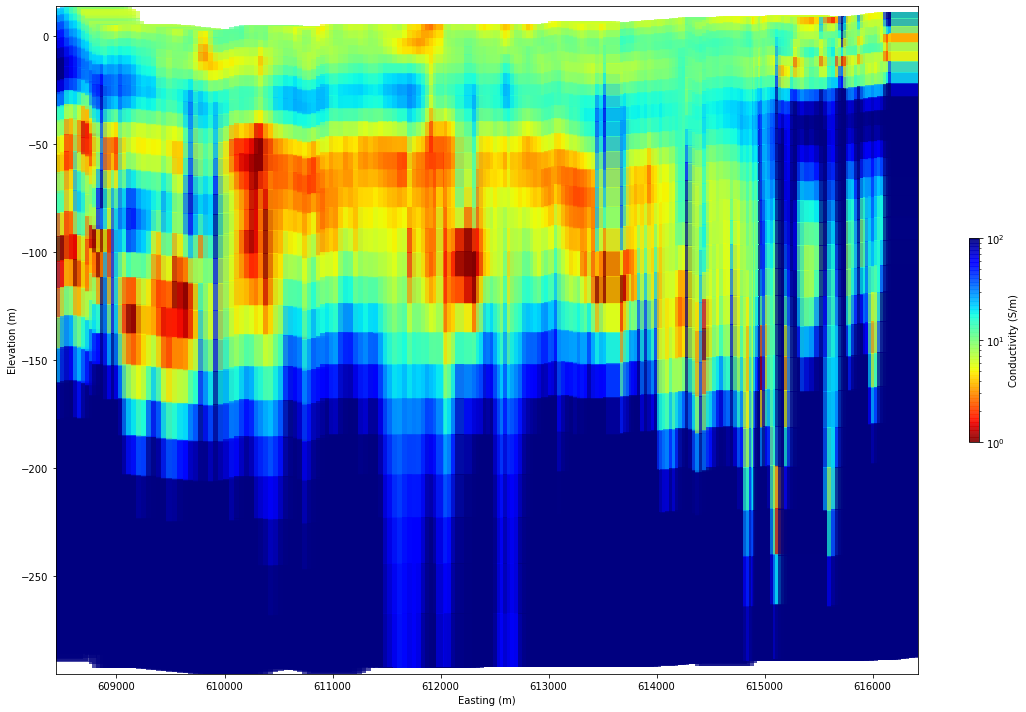

In [217]:
from matplotlib.colors import LogNorm
from simpegEM1D import ModelIO
nskip = 1
i_iter = 20
IO = ModelIO(
    hz=hz,
    topography=topo[1:,:], 
    physical_property=1./np.exp(Utils.mkvc(save_model.outDict[i_iter]['m'].reshape((hz.size, n_sounding), order='F')[:,::nskip])),
    line=np.repeat(line, n_sounding)[::nskip].astype(float)
)

IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r', aspect=20, clim=(1, 100), dx=250, i_line=0)

In [218]:
save_model.outDict

{1: {'iter': 1,
  'beta': 50789.68360811762,
  'phi_d': 566414145.454601,
  'phi_m': 0.42853789052615976,
  'f': 4670905956.628558,
  'm': array([-3.35299012, -3.37396148, -3.37906508, ..., -3.30210968,
         -3.30201697, -3.3107969 ]),
  'dpred': array([-1.61647383e-10, -1.39476655e-10, -1.17745307e-10, ...,
         -1.14703857e-12, -6.49677202e-13, -3.58571750e-13]),
  'eps_p': None,
  'eps_q': None,
  'lps': 0.0,
  'lpx': 1.0},
 2: {'iter': 2,
  'beta': 25394.84180405881,
  'phi_d': 75236365.83630483,
  'phi_m': 1.045192675752889,
  'f': 566438100.7430145,
  'm': array([-2.62644825, -2.79814235, -3.09751918, ..., -4.16695907,
         -4.26670505, -4.36369428]),
  'dpred': array([-1.88474277e-10, -1.57463800e-10, -1.28301074e-10, ...,
         -1.18444272e-12, -6.40013152e-13, -3.29692440e-13]),
  'eps_p': None,
  'eps_q': None,
  'lps': 0.0,
  'lpx': 1.0},
 3: {'iter': 3,
  'beta': 12697.420902029406,
  'phi_d': 11216206.435549939,
  'phi_m': 1.6508063404028952,
  'f': 75258186